# Objectives:
For each Featurization(BOWs, TF-IDF, AVG-W2V, TF-IDF W2V) we need to split the data based on Time Based Slicing and apply clustering algorithms.

Use elbow method to find hyperparameters.

We are not using target variable(y) here.

In [189]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [190]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'
#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [191]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
# sort reviews based on ProductId

In [192]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape
# Remove duplicate reviews

(364173, 10)

In [193]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [194]:
#stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [195]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words    
    final_string.append(str1)
    i+=1

In [196]:
final['CleanedText']=final_string
final = final.sort_values(['Time'], ascending=[True])
final.head()

Id   ProductId          UserId               ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
138706                     0                       0  positive  939340800   
138683                     2                       2  positive  940809600   
417839                     0                       0  positive  944092800   
346055                     1                       2  positive  944438400   
417838                     0                       0  positive  946857600   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   
346055                            A modern day fairy tale   
417838                                         FANTASTIC!   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
417839  Beetlejuice is a well written movie ..... ever...   
346055  A twist of rumplestiskin captured on film, sta...   
417838  Beetlejuice is an excellent and funny movie. K...   

                                              CleanedText  
138706  b'this witti littl book make son laugh loud re...  
138683  b'can rememb see the show when air televis yea...  
417839  b'beetlejuic well written movi everyth about e...  
346055  b'twist rumplestiskin captur film star michael...  
417838  b'beetlejuic excel and funni movi keaton hilar...

In [9]:
final = final.tail(100000)

In [10]:
X = final['CleanedText']

# BOW

In [11]:
# code for Bag Of Words calculation
count_vect = CountVectorizer()
# calculate BOW of trainning data
X_train = count_vect.fit_transform(X)

In [12]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)


C:\Users\ABHISEK\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [13]:
from sklearn.cluster import KMeans
k_means_cost = []
for k in range (1, 11):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1, algorithm = 'auto').fit(X_train)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
    # Sum of distances of samples to their closest cluster center
    k_means_cost.append(kmeans_model.inertia_)

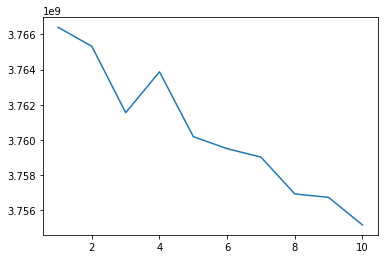

In [14]:
plt.plot(range (1, 11), k_means_cost)

In [15]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=8, init='k-means++', random_state=1, algorithm = 'auto').fit(X_train)

In [16]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = {}
cluster1 = {}
cluster2 = {}
cluster3 = {}
cluster4 = {}
cluster5 = {}
cluster6 = {}
cluster7 = {}

for i in pbar(range(X_train.shape[0])):
    cx = scipy.sparse.coo_matrix(X_train[i, :])
    if kmeans_model.labels_[i] == 0:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster0:
                #cluster0.append(count_vect.get_feature_names()[j])
                cluster0[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 1:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster1:
                #cluster1.append(count_vect.get_feature_names()[j])
                cluster1[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 2:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster2:
                #cluster2.append(count_vect.get_feature_names()[j])
                cluster2[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 3:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster3:
                #cluster3.append(count_vect.get_feature_names()[j])
                cluster3[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 4:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster4:
                #cluster4.append(count_vect.get_feature_names()[j])
                cluster4[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 5:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster5:
                #cluster5.append(count_vect.get_feature_names()[j])
                cluster5[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 6:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster6:
                #cluster6.append(count_vect.get_feature_names()[j])
                cluster6[count_vect.get_feature_names()[j]] = j
    elif kmeans_model.labels_[i] == 7:
        for j in cx.col:
            if count_vect.get_feature_names()[j]  not in cluster7:
                #cluster7.append(count_vect.get_feature_names()[j])
                cluster7[count_vect.get_feature_names()[j]] = j

100% |########################################################################|


In [18]:
#dump data in a file
import pickle
pickle_out = open("cluster0.pickle","wb")
pickle.dump(cluster0, pickle_out)
pickle_out.close()

In [19]:
#dump data in a file
import pickle
pickle_out = open("cluster1.pickle","wb")
pickle.dump(cluster1, pickle_out)
pickle_out.close()

In [20]:
#dump data in a file
import pickle
pickle_out = open("cluster2.pickle","wb")
pickle.dump(cluster2, pickle_out)
pickle_out.close()

In [21]:
#dump data in a file
import pickle
pickle_out = open("cluster3.pickle","wb")
pickle.dump(cluster3, pickle_out)
pickle_out.close()

In [22]:
#dump data in a file
import pickle
pickle_out = open("cluster4.pickle","wb")
pickle.dump(cluster4, pickle_out)
pickle_out.close()

In [23]:
#dump data in a file
import pickle
pickle_out = open("cluster5.pickle","wb")
pickle.dump(cluster5, pickle_out)
pickle_out.close()

In [24]:
#dump data in a file
import pickle
pickle_out = open("cluster6.pickle","wb")
pickle.dump(cluster6, pickle_out)
pickle_out.close()

In [25]:
#dump data in a file
import pickle
pickle_out = open("cluster7.pickle","wb")
pickle.dump(cluster7, pickle_out)
pickle_out.close()

# TFIDF

In [201]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X_tf_idf_train = tf_idf_vect.fit_transform(X)

In [188]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_tf_idf_train)
# transform both train and test data
X_tf_idf_train = scaler.transform(X_tf_idf_train)

In [189]:
from sklearn.cluster import KMeans
k_means_cost = []
for k in range (1, 11):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1, algorithm = 'auto').fit(X_tf_idf_train)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
    # Sum of distances of samples to their closest cluster center
    k_means_cost.append(kmeans_model.inertia_)

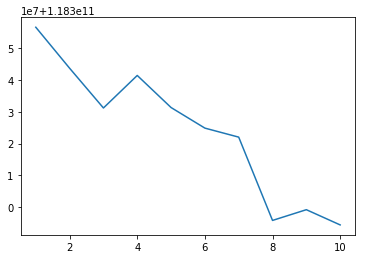

In [190]:
plt.plot(range (1, 11), k_means_cost)

In [191]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=8, init='k-means++', random_state=1, algorithm = 'auto').fit(X_tf_idf_train)

In [14]:
kmeans_model.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00547729, 0.00316251, 0.00316251, ..., 0.00316251, 0.00316251,
        0.00316251],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [186]:
for i,j in zip(kmeans_model.cluster_centers_[0],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        print(i,j)

2.340061195198555 again
23.71561053159911 again they
2.414373194243503 and
32.36641469001074 and bring
31.747870276269893 and crumbl
4.289413114226296 and have
2.5324755251400544 and the
2.1146648115768305 are
5.942056488443028 are not
18.371776744322457 are quit
3.9044787664280443 back
76.45964458886739 back fond
2.458610178472189 been
46.79600597181716 been want
3.276074565938028 bit
251.35823303829773 bit broken
8.302511934661045 bring
18.611354200849643 bring back
8.227623357433014 broken
22.92640713930578 broken and
12.341359733736475 bubbl
29.319589981499334 bubbl wrap
1.1885741341545177 but
4.4634323499168 but the
4.151577777920752 came
40.986133274163265 came well
2.0450386308730275 chocol
49.86213699514908 chocol coat
8.649906799442357 coat
36.78369749160996 coat the
3.522279647913379 come
14.096139212256562 come from
6.998719712492768 cooki
57.186366811069476 cooki made
41.78084244463642 cooki not
22.171112295729163 cooki the
11.191382046349274 crumbl
49.54249643561123 crumbl

In [192]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

In [194]:
cluster0_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[0],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster0_tfidf = cluster0_tfidf + j + ' '

In [195]:
cluster0_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster0_tfidf) 

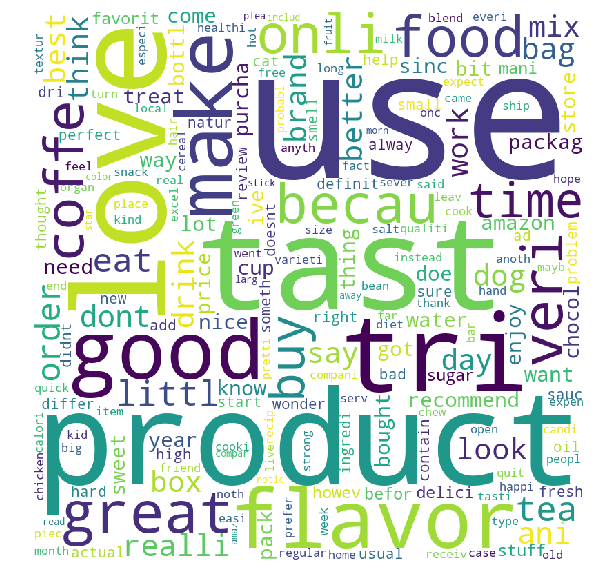

In [196]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster0_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [197]:
cluster1_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[1],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster1_tfidf = cluster1_tfidf + j + ' '

In [198]:
cluster1_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster1_tfidf) 

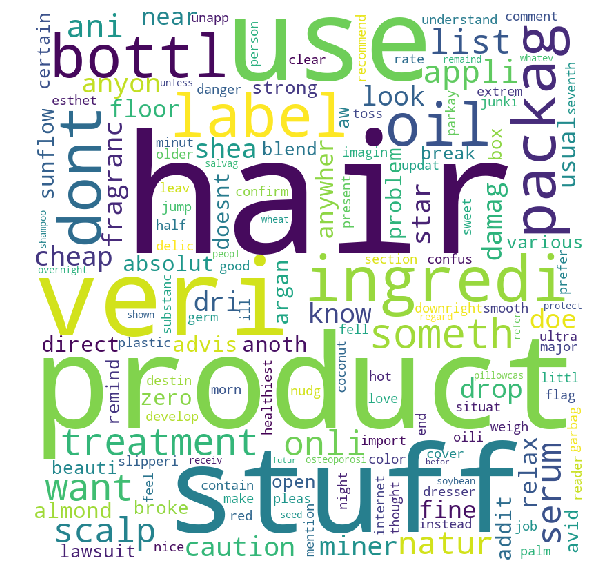

In [199]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster1_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [200]:
cluster2_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[2],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster2_tfidf = cluster2_tfidf + j + ' '

In [201]:
cluster2_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster2_tfidf) 

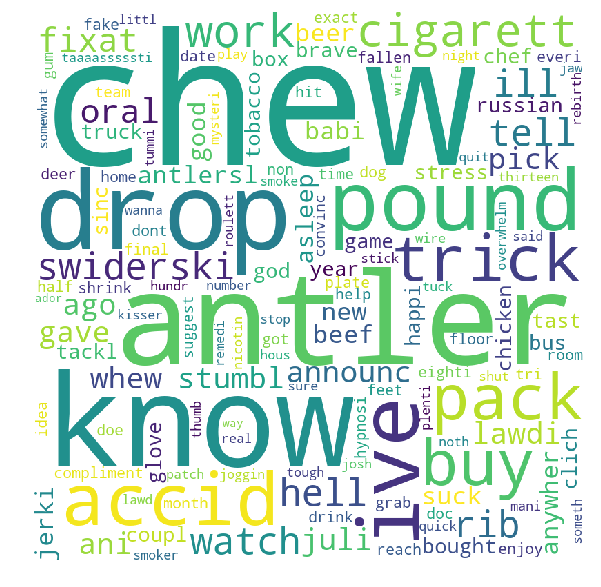

In [202]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster2_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [203]:
cluster3_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[3],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster3_tfidf = cluster3_tfidf + j + ' '

In [204]:
cluster3_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster3_tfidf) 

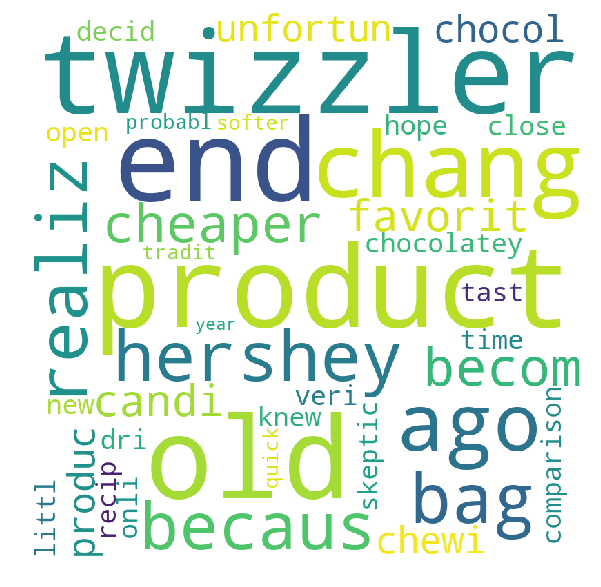

In [205]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster3_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [206]:
cluster4_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[4],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster4_tfidf = cluster4_tfidf + j + ' '

In [207]:
cluster4_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster4_tfidf) 

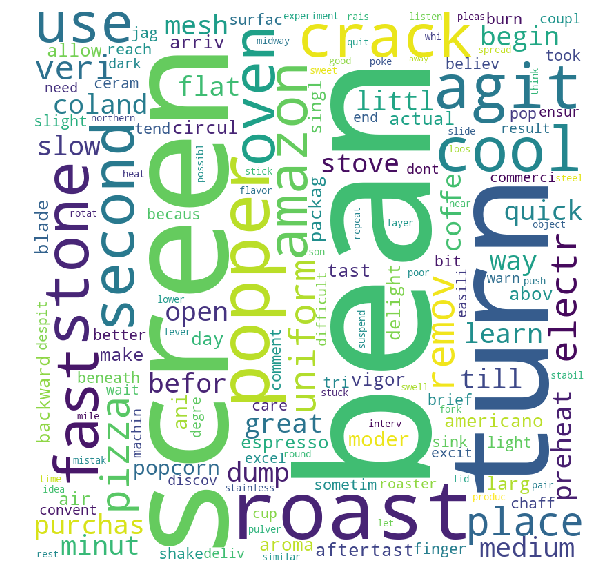

In [208]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster4_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [209]:
cluster5_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[5],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster5_tfidf = cluster5_tfidf + j + ' '

In [210]:
cluster5_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster5_tfidf) 

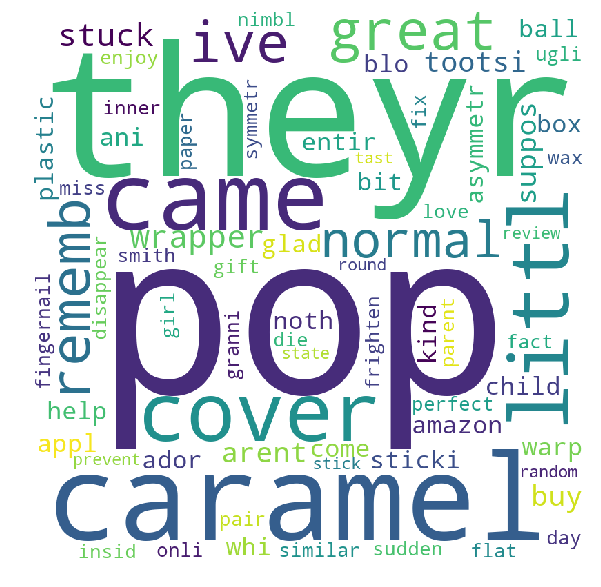

In [211]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster5_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [212]:
cluster6_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[6],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster6_tfidf = cluster6_tfidf + j + ' '

In [213]:
cluster6_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster6_tfidf) 

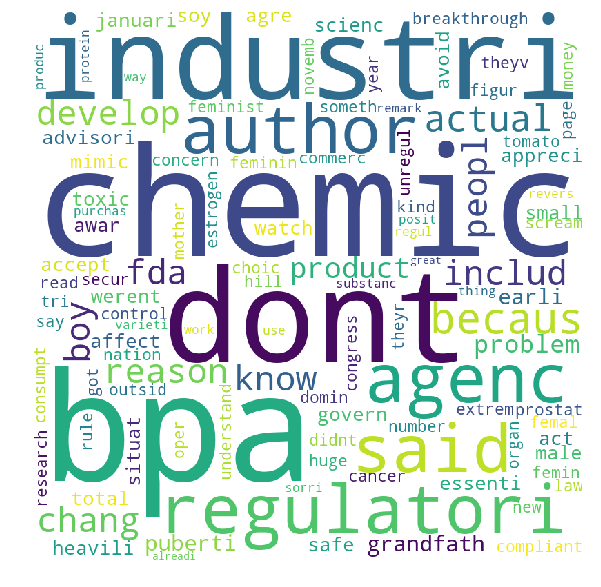

In [214]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster6_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [215]:
cluster7_tfidf = ' '
for i,j in zip(kmeans_model.cluster_centers_[7],np.array(tf_idf_vect.get_feature_names())):
    if i != 0:
        cluster7_tfidf = cluster7_tfidf + j + ' '

In [216]:
cluster7_wordcloud_tfidf = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cluster7_tfidf) 

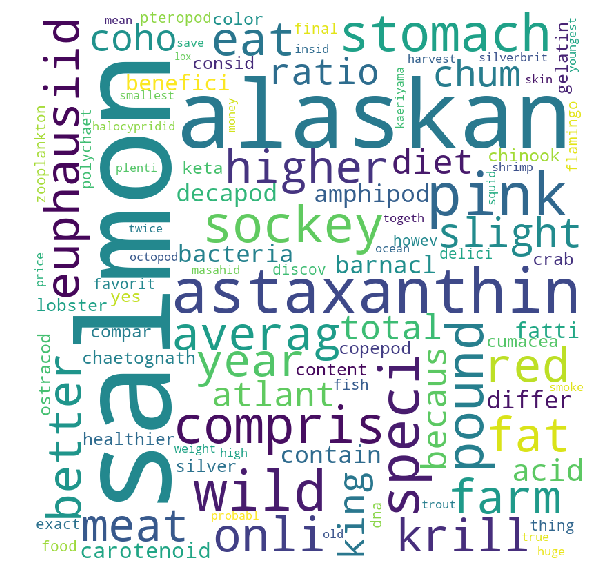

In [217]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(cluster7_wordcloud_tfidf) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# AvgW2V

In [18]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [19]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [20]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

C:\Users\ABHISEK\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


100000
50


In [21]:
df_train = pd.DataFrame(sent_vectors)
df_train = df_train.fillna(df_train.mean())
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train data
standardized_data_train_avgw2v = scaler.transform(df_train)

In [222]:
from sklearn.cluster import KMeans
k_means_cost = []
for k in range (1, 11):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1, algorithm = 'auto').fit(standardized_data_train_avgw2v)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
    # Sum of distances of samples to their closest cluster center
    k_means_cost.append(kmeans_model.inertia_)

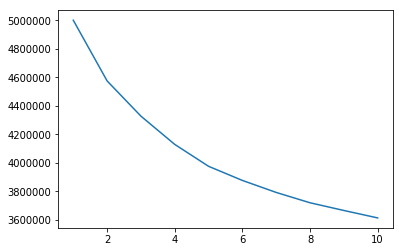

In [223]:
plt.plot(range (1, 11), k_means_cost)

In [22]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=8, init='k-means++', random_state=1, algorithm = 'auto').fit(standardized_data_train_avgw2v)

In [103]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []

for i in pbar(range(standardized_data_train_avgw2v.shape[0])):
    if kmeans_model.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 2:
        cluster2.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 3:
        cluster3.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 4:
        cluster4.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 5:
        cluster5.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 6:
        cluster6.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 7:
        cluster7.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


In [195]:
def show_cluster(cluster, cluster_no):
    
    from wordcloud import WordCloud, STOPWORDS
    stopwords = set(STOPWORDS)
    global cluster_avgw2v
    global cluster_wordcloud_avgw2v
    cluster_avgw2v = {}
    cluster_avgw2v[cluster_no] = []
    cluster_wordcloud_avgw2v = {}
    cluster_wordcloud_avgw2v[cluster_no] = []
    for i in cluster:
        for j in i.split(" "):
            if j not in cluster_avgw2v[cluster_no] and stopwords:
                cluster_avgw2v[cluster_no].append(j)
      
    cluster_wordcloud_avgw2v[cluster_no] = WordCloud(width = 800, height = 800,  
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(cluster_avgw2v[cluster_no]))
    
        # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(cluster_wordcloud_avgw2v[cluster_no]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

WordCloud for Cluster ==> 0


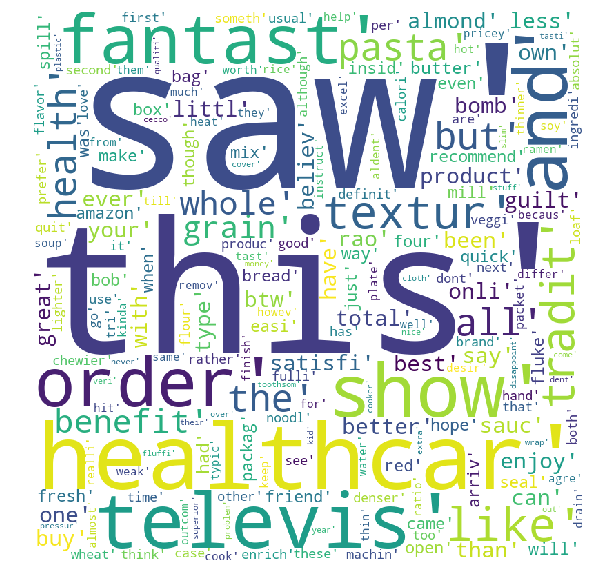

WordCloud for Cluster ==> 1


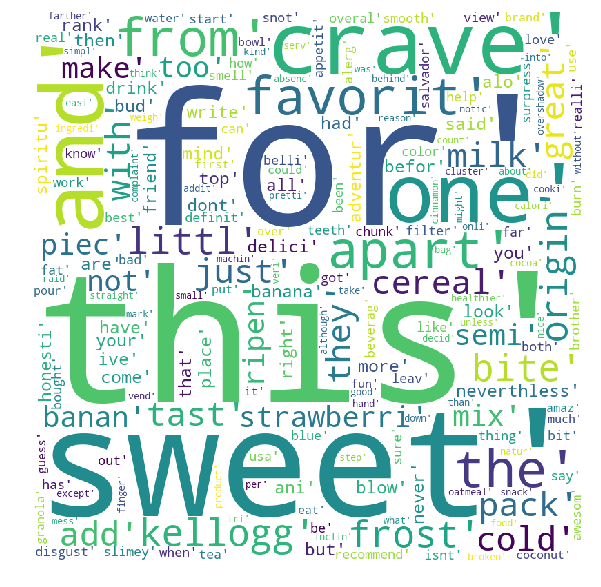

WordCloud for Cluster ==> 2


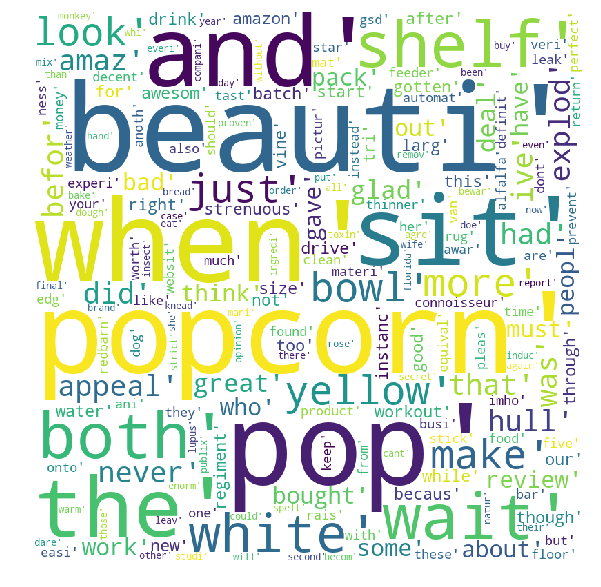

WordCloud for Cluster ==> 3


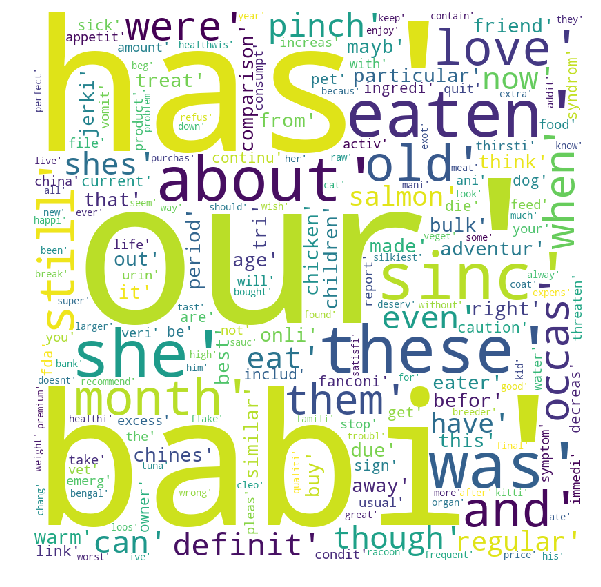

WordCloud for Cluster ==> 4


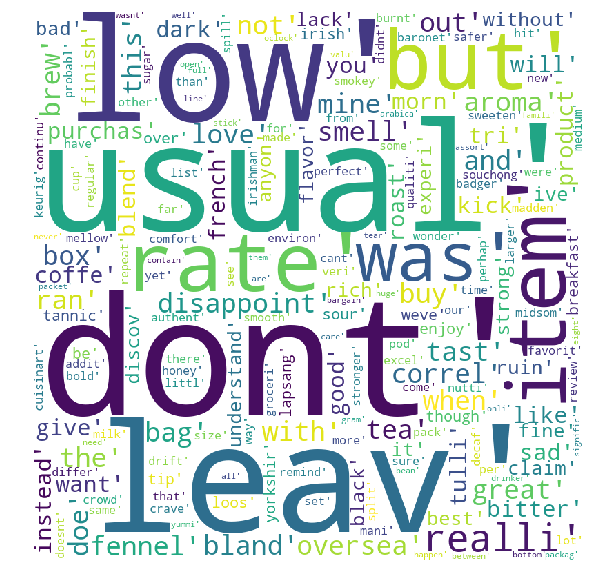

WordCloud for Cluster ==> 5


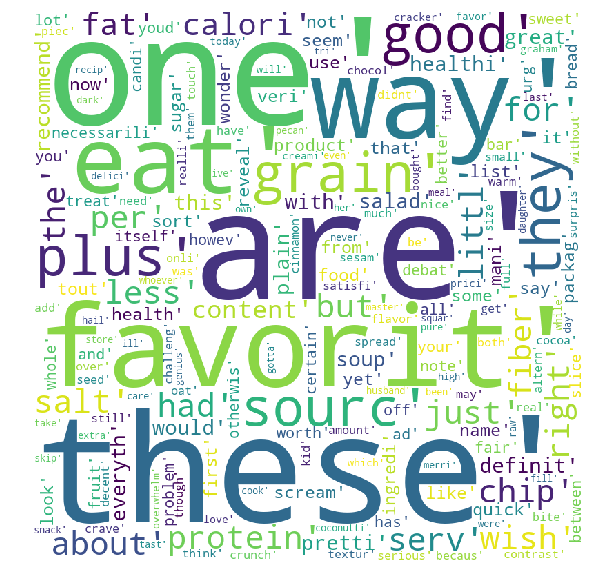

WordCloud for Cluster ==> 6


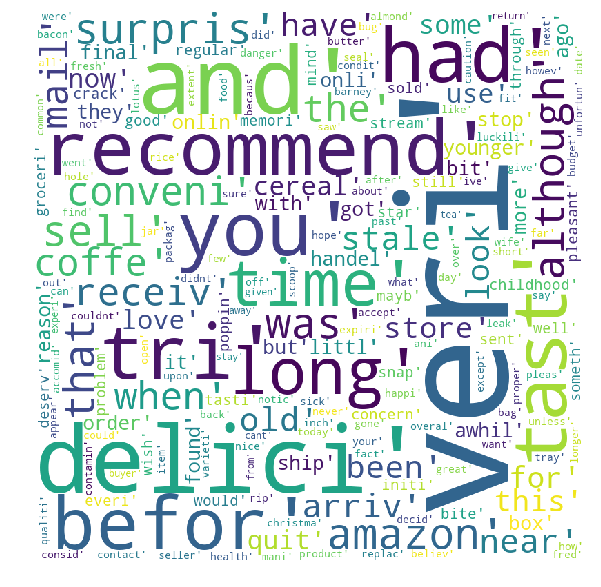

WordCloud for Cluster ==> 7


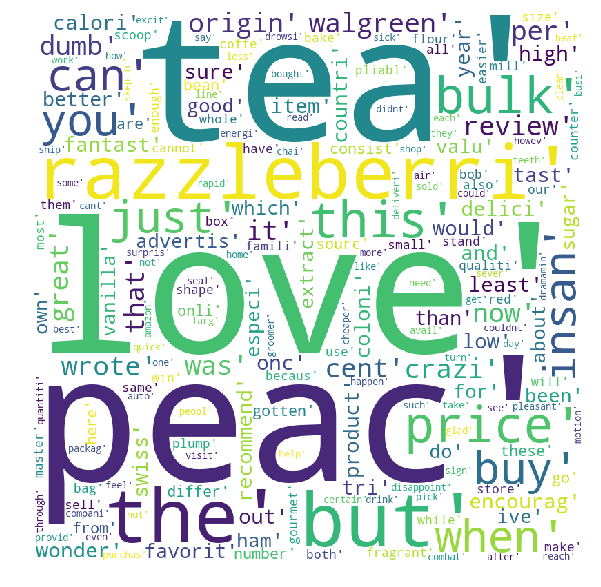

In [198]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)
print("WordCloud for Cluster ==> 2")
show_cluster(cluster2, 2)
print("WordCloud for Cluster ==> 3")
show_cluster(cluster3, 3)
print("WordCloud for Cluster ==> 4")
show_cluster(cluster4, 4)
print("WordCloud for Cluster ==> 5")
show_cluster(cluster5, 5)
print("WordCloud for Cluster ==> 6")
show_cluster(cluster6, 6)
print("WordCloud for Cluster ==> 7")
show_cluster(cluster7, 7)

# TFIDF-W2V

In [199]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [200]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [202]:
# TF-IDF weighted Word2Vec
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [204]:
df_train = pd.DataFrame(tfidf_sent_vectors)
df_train = df_train.fillna(df_train.mean())


from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_tf_idfw2v_train = scaler.transform(df_train)

In [205]:
from sklearn.cluster import KMeans
k_means_cost = []
for k in range (1, 11):
 
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    kmeans_model = KMeans(n_clusters=k, random_state=1, algorithm = 'auto').fit(standardized_data_tf_idfw2v_train)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = kmeans_model.labels_
    # Sum of distances of samples to their closest cluster center
    k_means_cost.append(kmeans_model.inertia_)

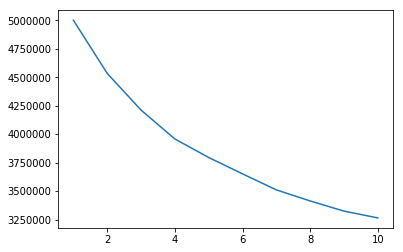

In [206]:
plt.plot(range (1, 11), k_means_cost)

In [207]:
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=8, init='k-means++', random_state=1, algorithm = 'auto').fit(standardized_data_tf_idfw2v_train)

In [208]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []

for i in pbar(range(standardized_data_tf_idfw2v_train.shape[0])):
    if kmeans_model.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 2:
        cluster2.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 3:
        cluster3.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 4:
        cluster4.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 5:
        cluster5.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 6:
        cluster6.append(X.iloc[i].decode('utf-8'))
    elif kmeans_model.labels_[i] == 7:
        cluster7.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


In [236]:
def show_cluster(cluster, cluster_no):
    
    from wordcloud import WordCloud, STOPWORDS
    stopwords = set(STOPWORDS)
    global cluster_avgw2v
    global cluster_wordcloud_avgw2v
    cluster_avgw2v = {}
    cluster_avgw2v[cluster_no] = []
    cluster_wordcloud_avgw2v = {}
    cluster_wordcloud_avgw2v[cluster_no] = []
    for i in cluster:
        for j in i.split(" "):
            if j not in (cluster_avgw2v[cluster_no] and stopwords):
                cluster_avgw2v[cluster_no].append(j)
      
    cluster_wordcloud_avgw2v[cluster_no] = WordCloud(width = 800, height = 800,  
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(str(cluster_avgw2v[cluster_no]))
    
        # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(cluster_wordcloud_avgw2v[cluster_no]) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

WordCloud for Cluster ==> 0


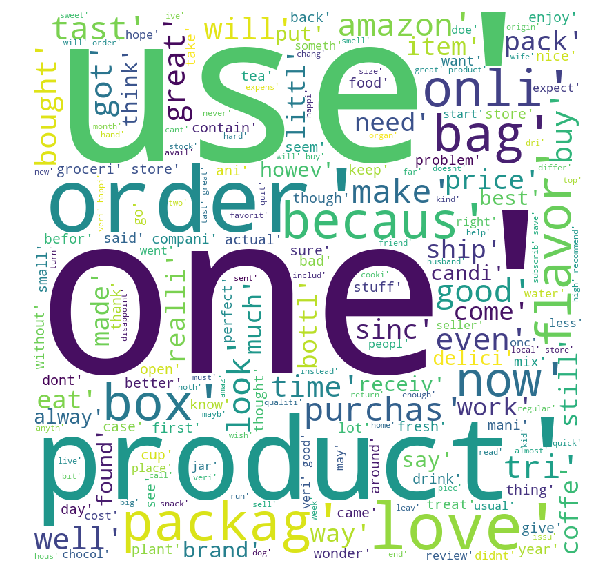

WordCloud for Cluster ==> 1


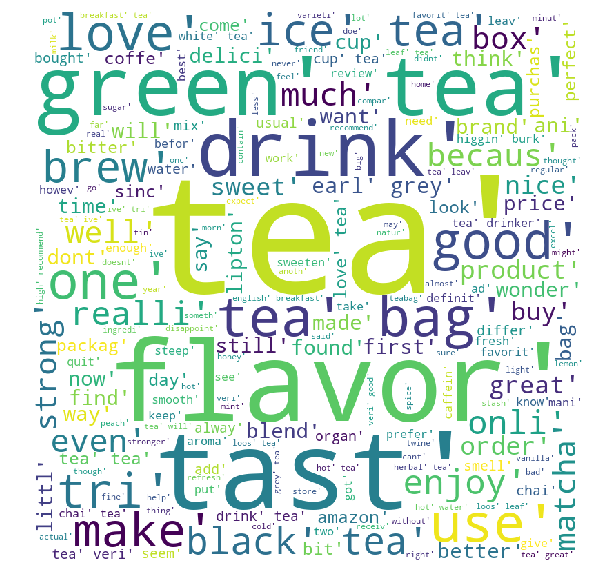

WordCloud for Cluster ==> 2


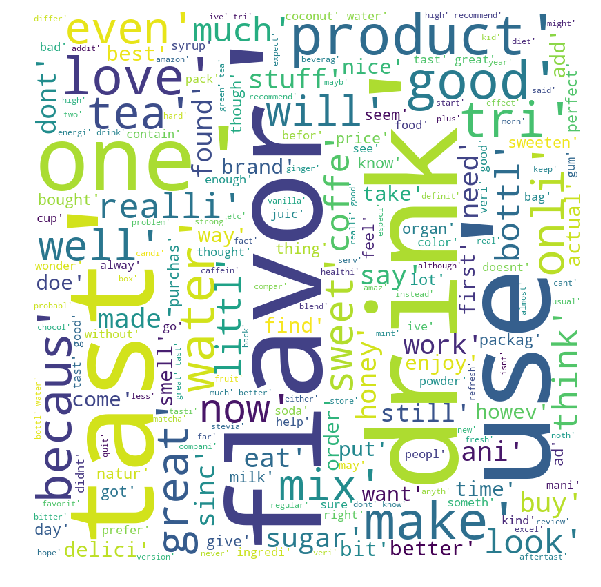

WordCloud for Cluster ==> 3


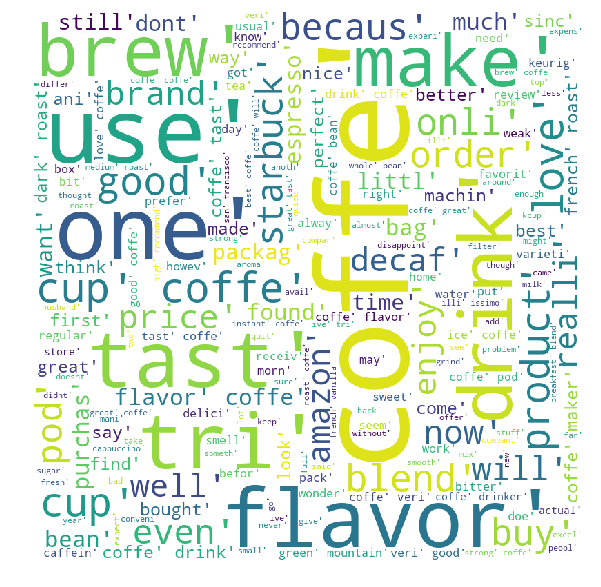

WordCloud for Cluster ==> 4


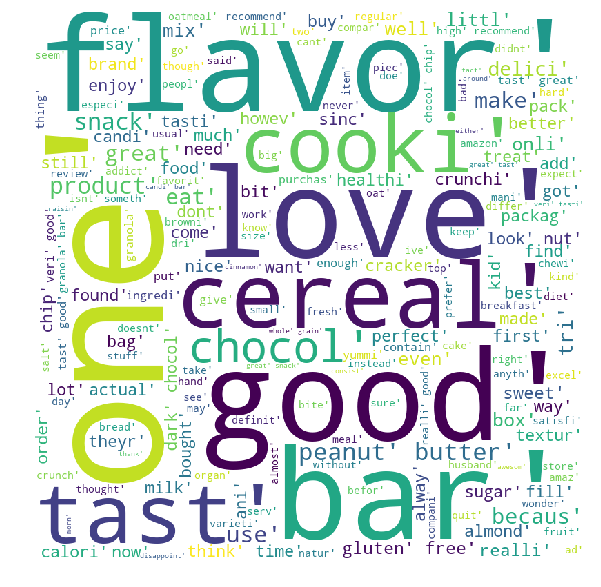

WordCloud for Cluster ==> 5


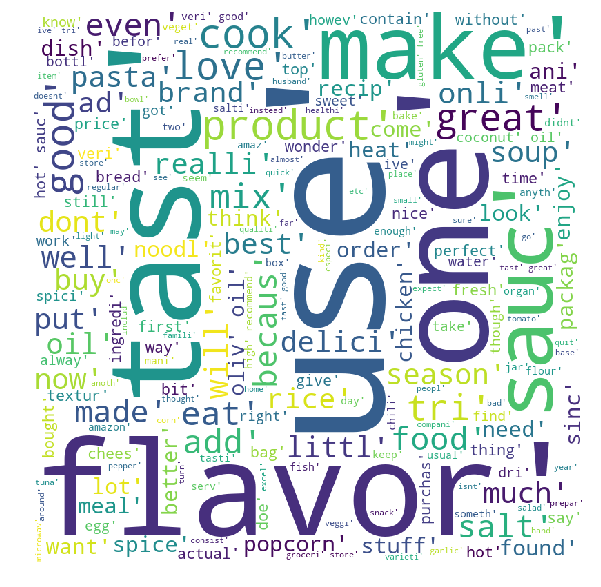

WordCloud for Cluster ==> 6


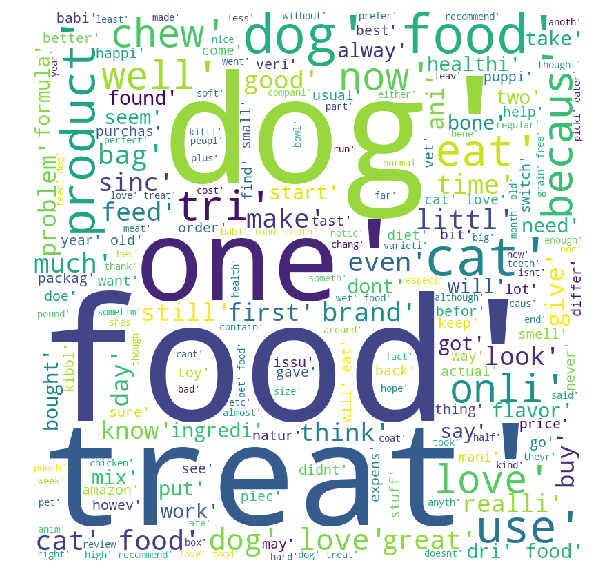

WordCloud for Cluster ==> 7


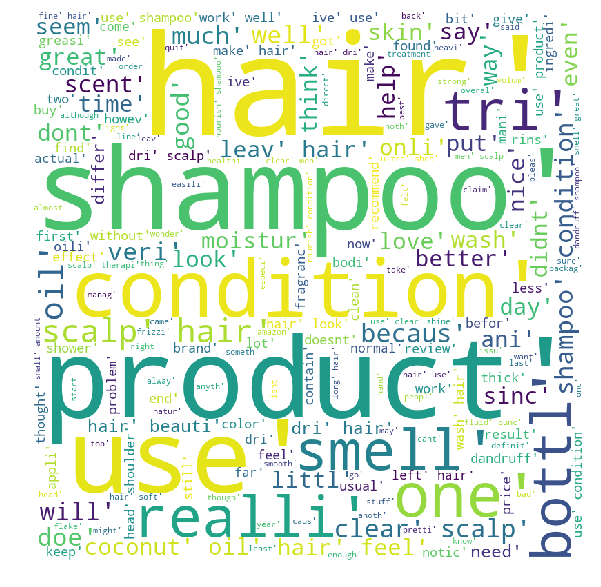

In [212]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)
print("WordCloud for Cluster ==> 2")
show_cluster(cluster2, 2)
print("WordCloud for Cluster ==> 3")
show_cluster(cluster3, 3)
print("WordCloud for Cluster ==> 4")
show_cluster(cluster4, 4)
print("WordCloud for Cluster ==> 5")
show_cluster(cluster5, 5)
print("WordCloud for Cluster ==> 6")
show_cluster(cluster6, 6)
print("WordCloud for Cluster ==> 7")
show_cluster(cluster7, 7)

# Agglomerative Clustering:

In [40]:
final = final.tail(5000)

In [41]:
X = final['CleanedText']

# BOW

In [29]:
# code for Bag Of Words calculation
count_vect = CountVectorizer()
# calculate BOW of trainning data
X_train = count_vect.fit_transform(X)

In [30]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


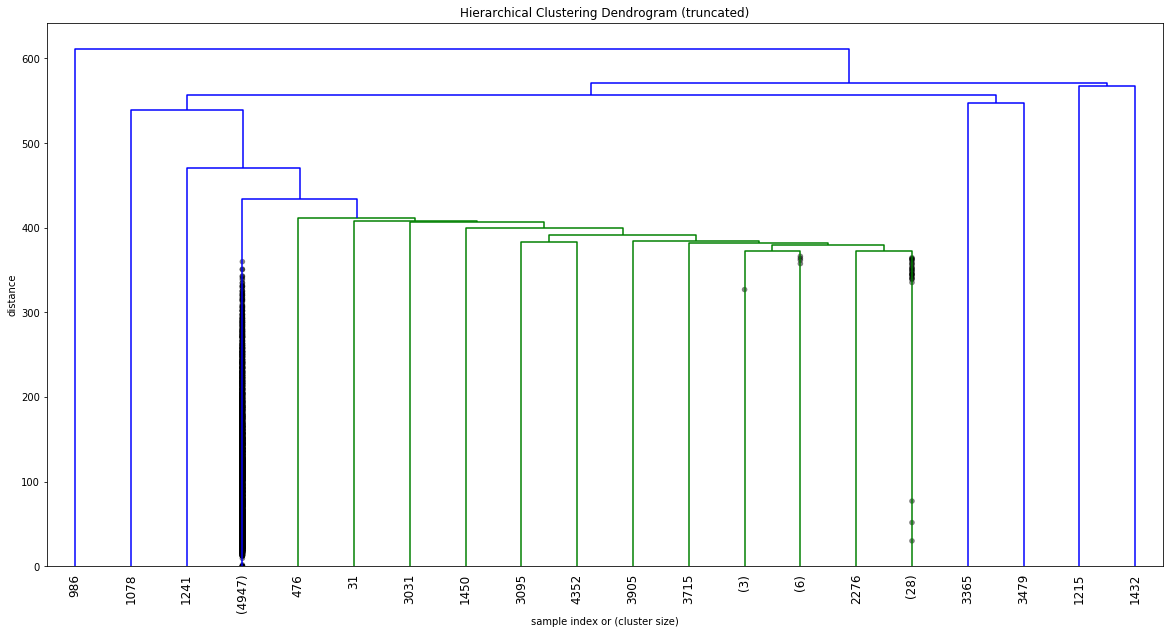

In [32]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# generate the linkage matrix
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X_train.todense(), 'ward')
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [117]:
from sklearn.cluster import AgglomerativeClustering
agg_model = AgglomerativeClustering(n_clusters=2).fit(X_train.todense())

In [118]:
pred = agg_model.fit_predict(X_train.toarray())

In [119]:
np.bincount(pred) # to find no of points in each cluster

array([9999,    1], dtype=int64)

In [113]:
agg_model.labels_

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [130]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []

for i in pbar(range(X_train.shape[0])):
    if agg_model.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


WordCloud for Cluster ==> 0


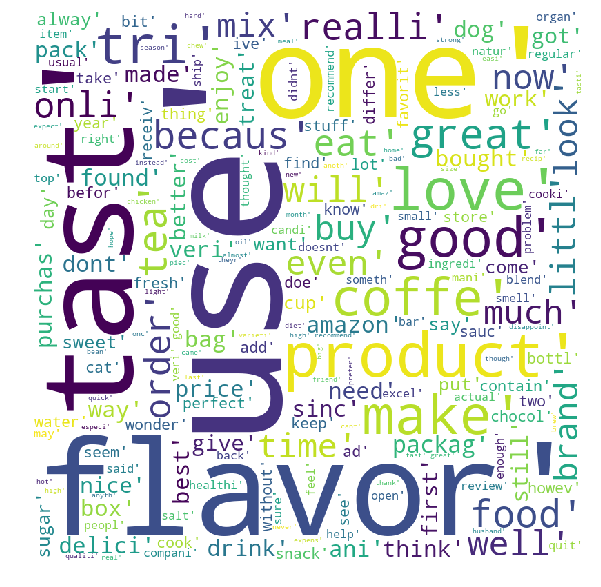

WordCloud for Cluster ==> 1


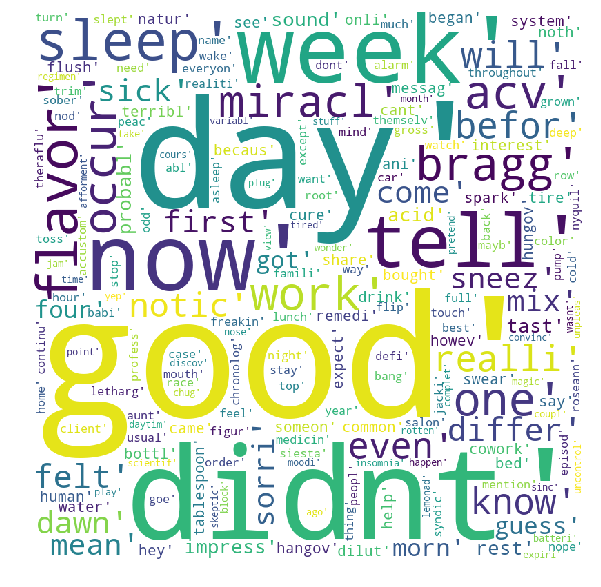

In [131]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)

# TF-IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X_tf_idf_train = tf_idf_vect.fit_transform(X)

In [12]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_tf_idf_train)
# transform both train and test data
X_tf_idf_train = scaler.transform(X_tf_idf_train)

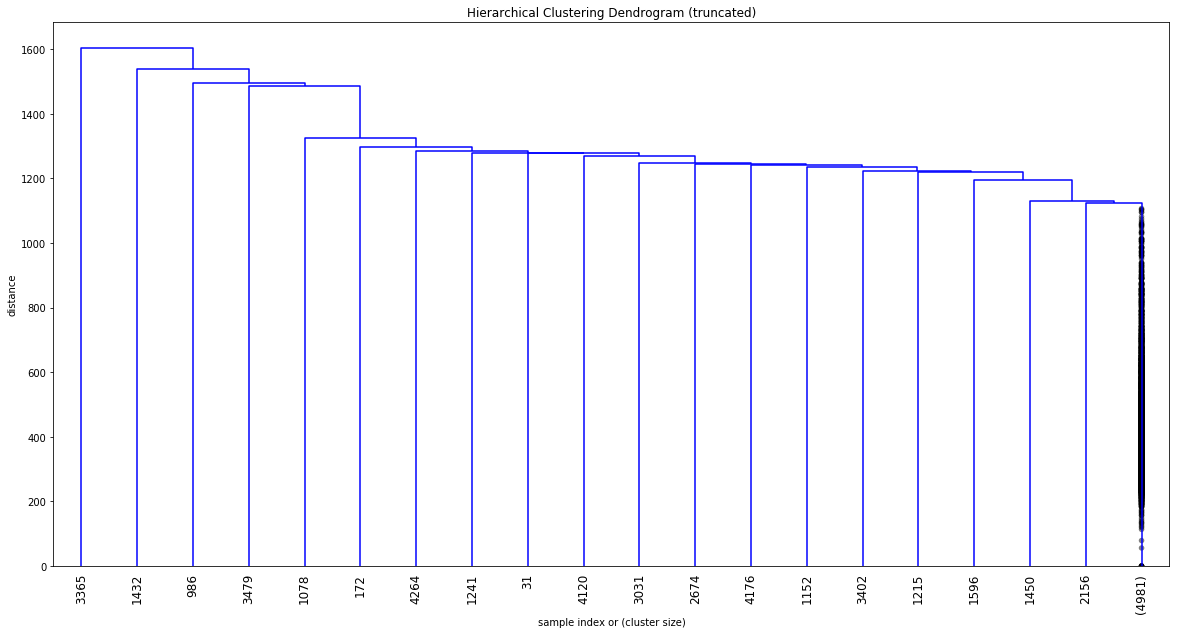

In [13]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# generate the linkage matrix
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X_tf_idf_train.toarray(), 'ward')
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering
agg_model = AgglomerativeClustering(n_clusters=2).fit(X_tf_idf_train.todense())

In [14]:
pred = agg_model.fit_predict(X_tf_idf_train.todense())

In [15]:
np.bincount(pred) # to find no of points in each cluster

array([4999,    1])

In [16]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []

for i in pbar(range(X_tf_idf_train.shape[0])):
    if agg_model.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


In [ ]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)

# AvgW2V

In [11]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [12]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [13]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
50


In [14]:
df_train = pd.DataFrame(sent_vectors)
df_train = df_train.fillna(df_train.mean())
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train data
standardized_data_train_avgw2v = scaler.transform(df_train)

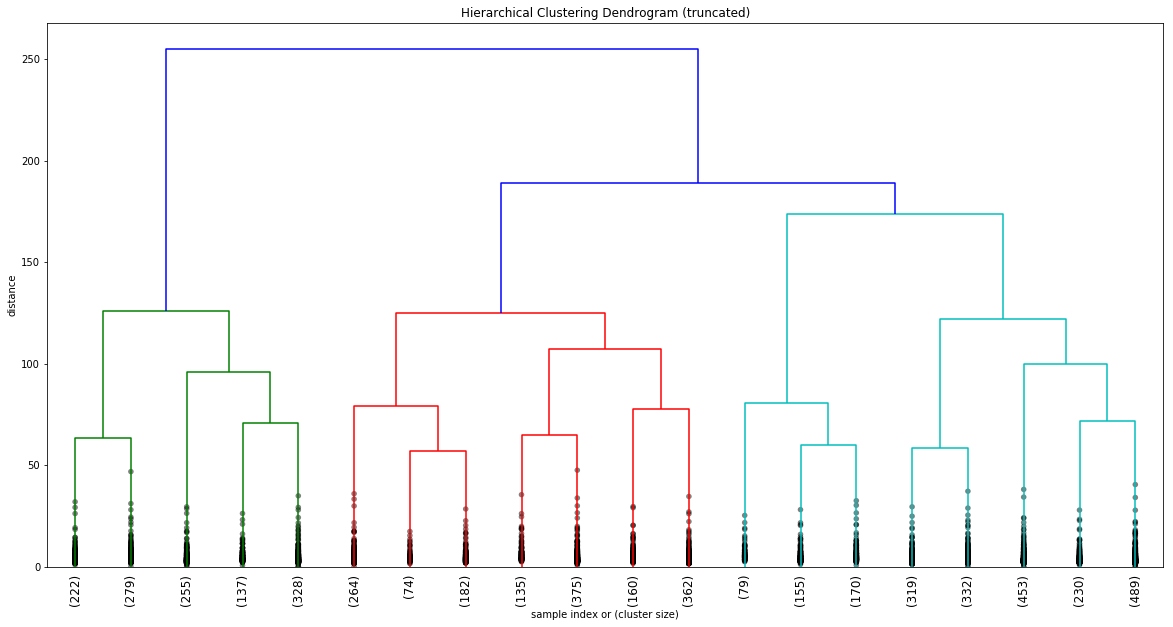

In [16]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# generate the linkage matrix
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(standardized_data_train_avgw2v, 'ward')
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [18]:
from sklearn.cluster import AgglomerativeClustering
agg_model = AgglomerativeClustering(n_clusters=3).fit(standardized_data_train_avgw2v)

In [20]:
pred = agg_model.fit_predict(standardized_data_train_avgw2v)

In [21]:
np.bincount(pred) # to find no of points in each cluster

array([2227, 1221, 1552])

In [27]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []
cluster2 = []

for i in pbar(range(standardized_data_train_avgw2v.shape[0])):
    if agg_model.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 2:
        cluster2.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


WordCloud for Cluster ==> 0


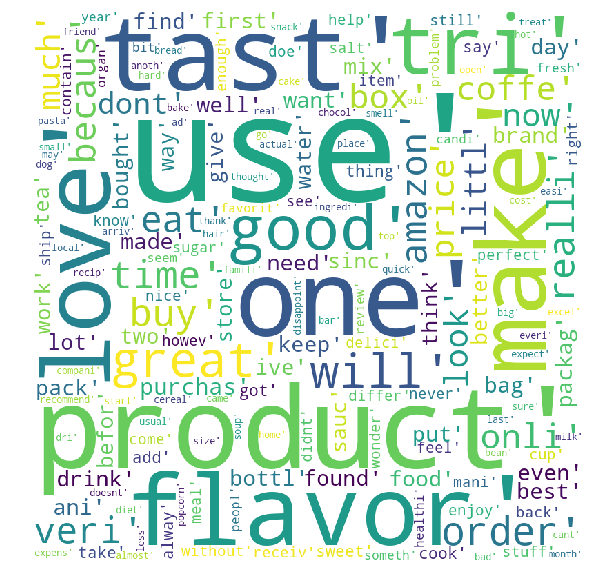

WordCloud for Cluster ==> 1


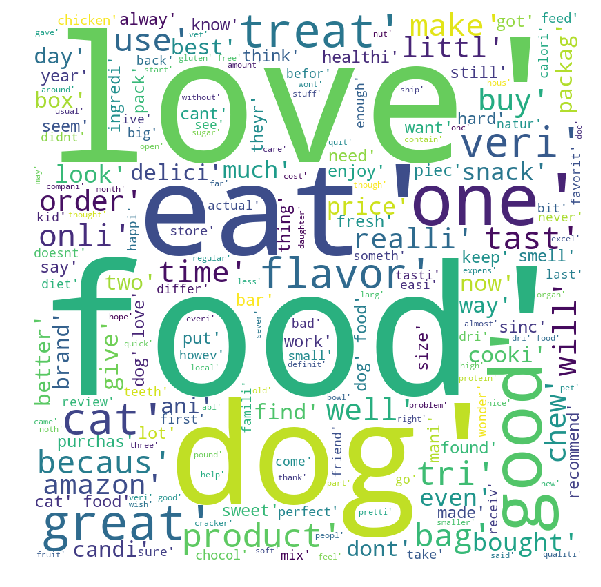

WordCloud for Cluster ==> 2


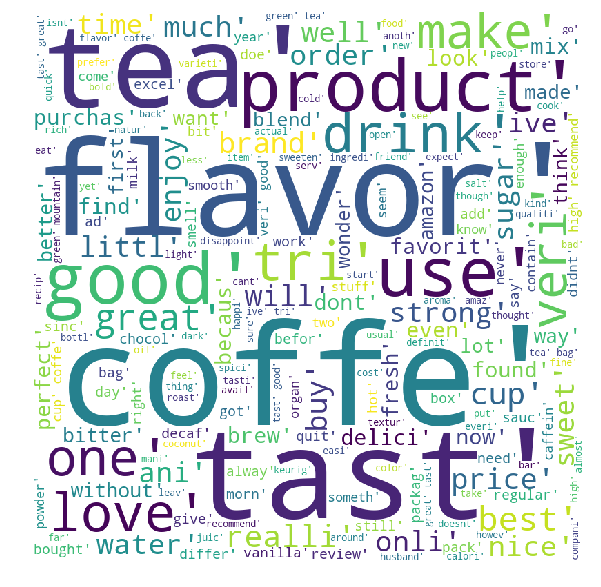

In [28]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)
print("WordCloud for Cluster ==> 2")
show_cluster(cluster2, 2)

# TFIDF-W2V

In [33]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [34]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [37]:
# TF-IDF weighted Word2Vec
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [38]:
df_train = pd.DataFrame(tfidf_sent_vectors)
df_train = df_train.fillna(df_train.mean())


from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_tf_idfw2v_train = scaler.transform(df_train)

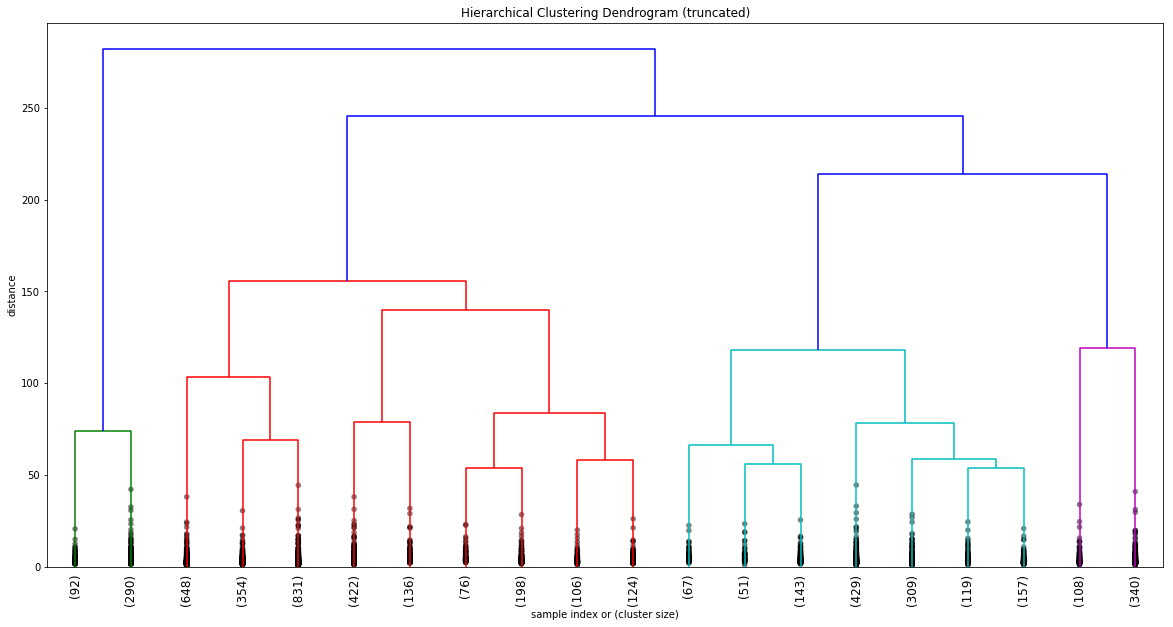

In [40]:
#https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
# generate the linkage matrix
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(standardized_data_tf_idfw2v_train, 'ward')
plt.figure(figsize=(20,10))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [42]:
from sklearn.cluster import AgglomerativeClustering
agg_model = AgglomerativeClustering(n_clusters=4).fit(standardized_data_tf_idfw2v_train)

In [43]:
pred = agg_model.fit_predict(standardized_data_tf_idfw2v_train)

In [44]:
np.bincount(pred) # to find no of points in each cluster

array([2895, 1275,  448,  382])

In [46]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

for i in pbar(range(standardized_data_train_avgw2v.shape[0])):
    if agg_model.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 2:
        cluster2.append(X.iloc[i].decode('utf-8'))
    elif agg_model.labels_[i] == 3:
        cluster3.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


WordCloud for Cluster ==> 0


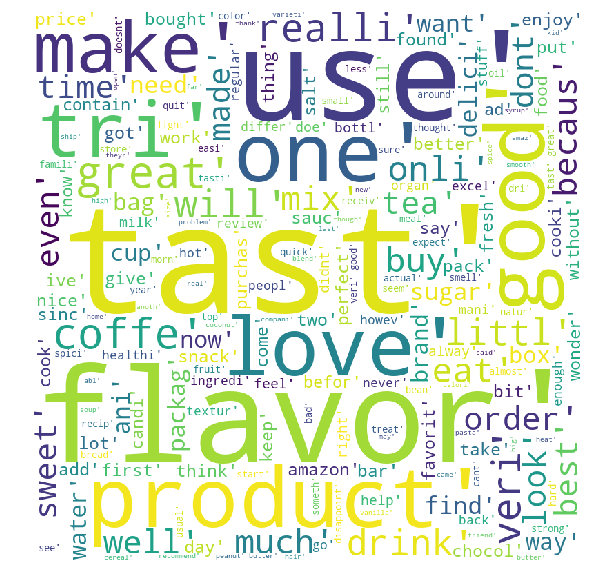

WordCloud for Cluster ==> 1


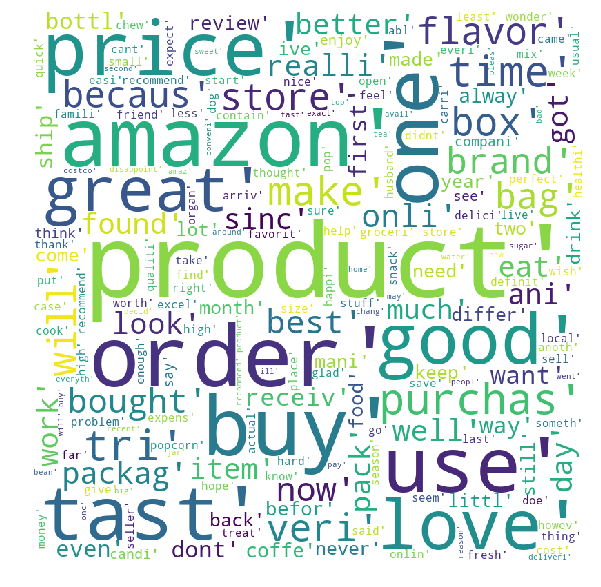

WordCloud for Cluster ==> 2


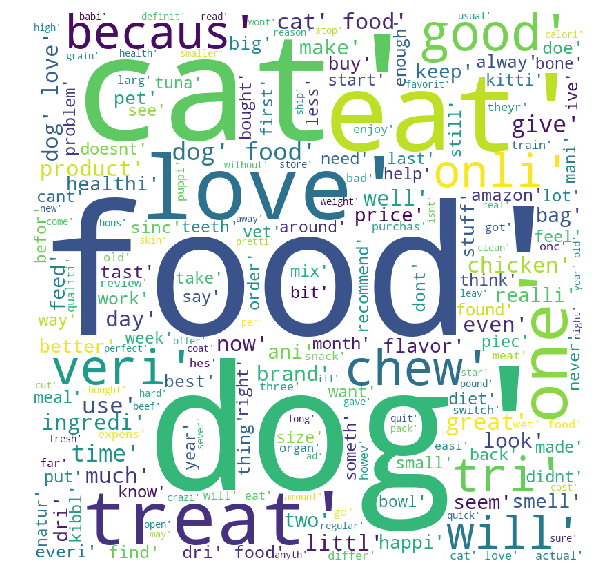

WordCloud for Cluster ==> 3


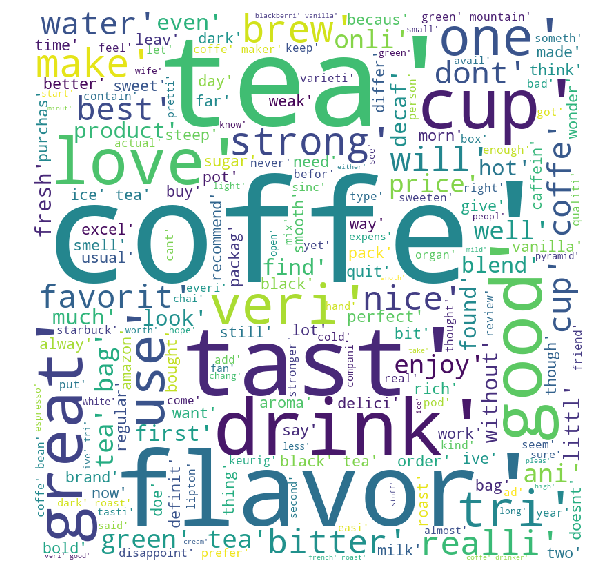

In [47]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)
print("WordCloud for Cluster ==> 2")
show_cluster(cluster2, 2)
print("WordCloud for Cluster ==> 3")
show_cluster(cluster3, 3)

# DBSCAN

# BOW

In [197]:
final = final.tail(5000)

In [198]:
X = final['CleanedText']

In [49]:
# code for Bag Of Words calculation
count_vect = CountVectorizer()
# calculate BOW of trainning data
X_train = count_vect.fit_transform(X)

In [50]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_train)
# transform both train and test data
X_train = scaler.transform(X_train)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [60]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [61]:
distance = []
for i,j in sorted(zip(range(5000), distances[:,9]), key = lambda x: x[1]):
    distance.append(j)

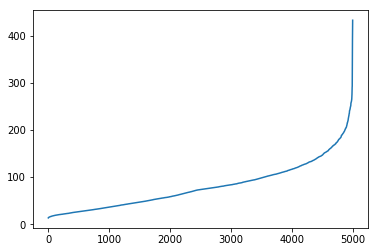

In [62]:
%matplotlib inline
plt.plot(range(5000), distance)

In [63]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=180, min_samples=10).fit(X_train)

In [64]:
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise = list(clustering.labels_).count(-1)

In [66]:
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 1
Estimated number of noise points: 207


In [67]:
pred = clustering.fit_predict(X_train.toarray())

# TF-IDF

In [69]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X_tf_idf_train = tf_idf_vect.fit_transform(X)

In [70]:
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(X_tf_idf_train)
# transform both train and test data
X_tf_idf_train = scaler.transform(X_tf_idf_train)

In [72]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X_tf_idf_train)
distances, indices = nbrs.kneighbors(X_tf_idf_train)

/home/abhisek1651990/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:212: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: "


In [73]:
distance = []
for i,j in sorted(zip(range(5000), distances[:,9]), key = lambda x: x[1]):
    distance.append(j)

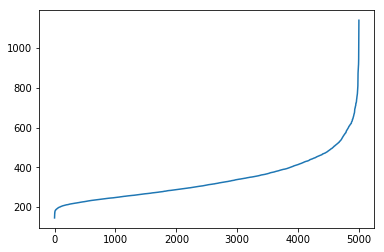

In [74]:
plt.plot(range(5000), distance)

In [75]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=500, min_samples=10).fit(X_tf_idf_train)

In [76]:
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise = list(clustering.labels_).count(-1)

In [77]:
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 1
Estimated number of noise points: 382


# AvgW2V

In [199]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [200]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [201]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
50


In [202]:
df_train = pd.DataFrame(sent_vectors)
df_train = df_train.fillna(df_train.mean())
from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train data
standardized_data_train_avgw2v = scaler.transform(df_train)

In [203]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(standardized_data_train_avgw2v)
distances, indices = nbrs.kneighbors(standardized_data_train_avgw2v)

In [204]:
distance = []
for i,j in sorted(zip(range(5000), distances[:,9]), key = lambda x: x[1]):
    distance.append(j)

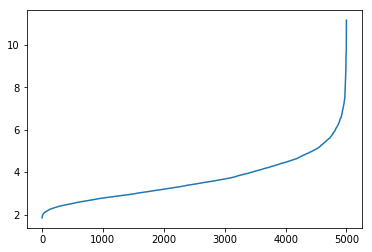

In [205]:
plt.plot(range(5000), distance)

In [215]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=5, min_samples=10).fit(standardized_data_train_avgw2v)

In [216]:
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise = list(clustering.labels_).count(-1)

In [217]:
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 1
Estimated number of noise points: 192


# TFIDF-W2V

In [218]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in X.values:
    filtered_sentence=[]
    sent=cleanhtml(sent.decode('utf-8'))
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [219]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [220]:
# TF-IDF weighted Word2Vec
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            try:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [221]:
df_train = pd.DataFrame(tfidf_sent_vectors)
df_train = df_train.fillna(df_train.mean())


from sklearn.preprocessing import StandardScaler
# prepare the scaler with train data
scaler = StandardScaler(with_mean=False).fit(df_train)
# transform both train and test data
standardized_data_tf_idfw2v_train = scaler.transform(df_train)

In [222]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(standardized_data_tf_idfw2v_train)
distances, indices = nbrs.kneighbors(standardized_data_tf_idfw2v_train)

In [223]:
distance = []
for i,j in sorted(zip(range(5000), distances[:,9]), key = lambda x: x[1]):
    distance.append(j)

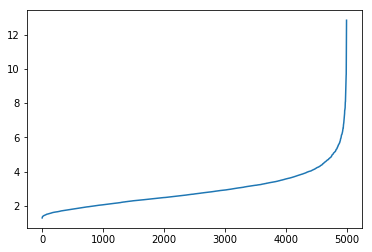

In [224]:
plt.plot(range(5000), distance)

In [231]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=3, min_samples=10).fit(standardized_data_tf_idfw2v_train)

In [232]:
n_clusters = len(set(clustering.labels_)) - (1 if -1 in clustering.labels_ else 0)
n_noise = list(clustering.labels_).count(-1)

In [233]:
print('Estimated number of clusters: %d' % n_clusters)
print('Estimated number of noise points: %d' % n_noise)

Estimated number of clusters: 2
Estimated number of noise points: 1001


In [188]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [238]:
import scipy
from progressbar import ProgressBar
pbar = ProgressBar()
cluster0 = []
cluster1 = []

for i in pbar(range(standardized_data_tf_idfw2v_train.shape[0])):
    if clustering.labels_[i] == 0:
        cluster0.append(X.iloc[i].decode('utf-8'))
    elif clustering.labels_[i] == 1:
        cluster1.append(X.iloc[i].decode('utf-8'))

100% |########################################################################|


WordCloud for Cluster ==> 0


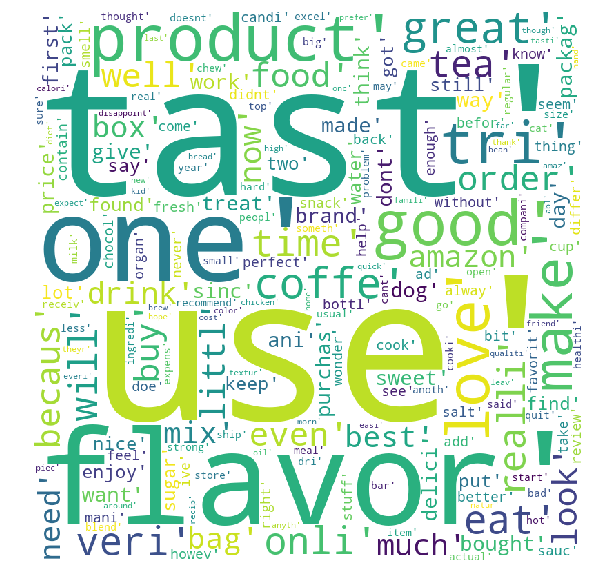

WordCloud for Cluster ==> 1


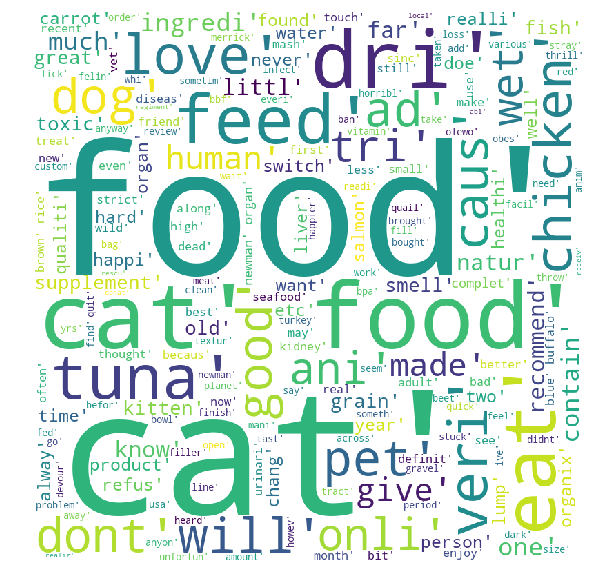

In [239]:
print("WordCloud for Cluster ==> 0")
show_cluster(cluster0, 0)
print("WordCloud for Cluster ==> 1")
show_cluster(cluster1, 1)

# Conclusion

In [245]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model", "hyper parameter- k", "hyper parameter- Eps", "No Of Cluster"]
x.add_row(["K-Means: (bow/tfidf/avgw2v/tfidf-avgw2v)", "8/8/8/8", "NA", "8/8/8/8"])
x.add_row(["Agglomerative Clustering:(bow/tfidf/avgw2v/tfidf-avgw2v)","NA" , "NA", "2/2/3/4"])
x.add_row(["DBSCAN: (bow/tfidf/avgw2v/tfidf-avgw2v)", "NA", "180/500/5/3", "1/1/1/2"])
print("Cluster Details: ")
print(x)

Cluster Details: 
+----------------------------------------------------------+--------------------+----------------------+---------------+
|                          Model                           | hyper parameter- k | hyper parameter- Eps | No Of Cluster |
+----------------------------------------------------------+--------------------+----------------------+---------------+
|         K-Means: (bow/tfidf/avgw2v/tfidf-avgw2v)         |      8/8/8/8       |          NA          |    8/8/8/8    |
| Agglomerative Clustering:(bow/tfidf/avgw2v/tfidf-avgw2v) |         NA         |          NA          |    2/2/3/4    |
|         DBSCAN: (bow/tfidf/avgw2v/tfidf-avgw2v)          |         NA         |     180/500/5/3      |    1/1/1/2    |
+----------------------------------------------------------+--------------------+----------------------+---------------+
